## Dependencies

In [ ]:
!pip install torch==1.10.0

In [ ]:
!pip install pytorch-lightning

In [4]:
import pandas as pd
import numpy as np 
import os
import re
import datetime

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc 
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import classification_report, confusion_matrix

from lstm_module import * # custom lstm library
from project_utils import * # custom utils library

base_folder = '/content/drive/MyDrive/Data project (VITA)/'

## Select data: Apple watch | MMS+ | AX3

In [5]:
# Choose: 'applewatch' or 'mms+' or 'ax3'
dataset_name = 'applewatch'
features, data_path, log_path, model_path = select_data(base_folder, dataset_name)

## Sequences creation

In [84]:
# Read labeled data
data = pd.read_csv(data_path)

In [85]:
# Normalization
data[features] = (data[features]-data[features].mean())/data[features].std()
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data['label'])
data['label'] = encoded_labels

In [86]:
# Create sequences
sequences = []
labels = []
data_cleaned = data.dropna()
groups = features.copy()
groups.append('label')
for series_id, group in data_cleaned[groups].groupby("label"):
  label = data_cleaned[data_cleaned['label'] == series_id].iloc[0].label
  if label==np.where(label_encoder.classes_=='no_label')[0].item():
    break
  for _, action in group[features].groupby(group[features].index.to_series().diff().ne(1).cumsum()):
    sequence_features = action[features]
    sequences.append((sequence_features, label))
    labels.append(label)

In [87]:
# Create training and test sequences (windows allowed from 1.5s to 3s per action: drop those below 1.5s and take the first 3s of those above 3s)
sequences_new = []
upper_bound = 128
lower_bound = 64
for seq in sequences:
  if len(seq[0])>=upper_bound:
    sequences_new.append((seq[0][:upper_bound], seq[1]))
  elif len(seq[0])>=lower_bound:
    sequences_new.append((seq[0], seq[1]))
pl.seed_everything(42)
train_sequences, test_sequences = train_test_split(sequences_new, test_size=0.15)
print('Number of training sequences is {} \nNumber of test sequences is {}'.format(len(train_sequences),len(test_sequences)))

Global seed set to 42


Number of training sequences is 3071 
Number of test sequences is 542


## Train model

In [88]:
# Set training parameters
num_epochs = 250
bsz = 25
data_module = InteractionsDataModule(train_sequences, test_sequences, bsz)
model = InteractionsPredictor(
    n_features=len(features),
    n_classes=len(label_encoder.classes_[:-1]), # without the class no_label
    train_len = len(train_sequences),
    test_len = len(test_sequences),
    bsz = bsz) 

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints", filename="best-checkpoint",
    save_top_k=1, verbose=True, monitor="val_loss", mode="min")

logger = TensorBoardLogger(log_path, name= "all_users")
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    max_epochs=num_epochs,
    gpus=1,
    progress_bar_refresh_rate=30
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7ff6c89b02d0>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7ff6c89b02d0>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Tr

In [89]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | model        | SequenceModel    | 812 K 
1 | criterion    | CrossEntropyLoss | 0     
2 | best_weights | SequenceModel    | 812 K 
--------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.500     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

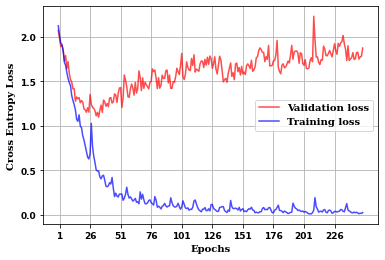

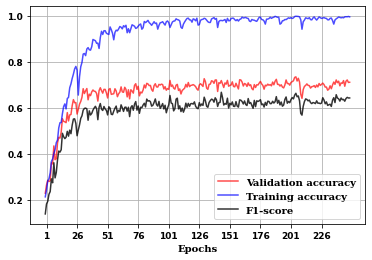

In [91]:
train_loss = model.loss_train
val_loss = model.loss_val
train_accuracy = model.acc_train
val_accuracy = model.acc_val
f1 = model.f1
plot_performance(base_folder, dataset_name, len(train_loss), val_accuracy, train_accuracy, f1, train_loss, val_loss, save=False)

In [98]:
torch.save(model.state_dict(),model_path)

In [14]:
#%reload_ext tensorboard
#%tensorboard --logdir ./applewatch_log

## Test model

In [113]:
model = InteractionsPredictor(
    n_features=len(features),
    n_classes=len(label_encoder.classes_)-1, # without the class no_label
    test_len = len(test_sequences),
    train_len = len(train_sequences),
    bsz = 5
    )
model.load_state_dict(torch.load(model_path))
model.model = model.best_weights
model.eval()

InteractionsPredictor(
  (model): SequenceModel(
    (lstm): LSTM(19, 256, num_layers=2, batch_first=True, dropout=0.75)
    (classifier): Linear(in_features=256, out_features=10, bias=True)
  )
  (criterion): CrossEntropyLoss()
  (best_weights): SequenceModel(
    (lstm): LSTM(19, 256, num_layers=2, batch_first=True, dropout=0.75)
    (classifier): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [114]:
# Test final model performance
dataloader_test = DataLoader(InteractionsDataset(test_sequences), batch_size = 25, shuffle = False,
        num_workers = cpu_count(),
        collate_fn=PadSequence()
    )
y_true = []
y_pred = []
model.to('cuda')
for i, batch in enumerate(dataloader_test):
    sequences, seq_lengths, labels = batch
    seq_pack = PACK(sequences, seq_lengths.to('cpu'), batch_first=True).to('cuda')
    outputs = model(seq_pack)
    predictions = torch.argmax(outputs[1], dim=1)
    y_true.extend(labels.to('cpu').data.numpy().astype(int))
    y_pred.extend(predictions.to('cpu').data.numpy().astype(int))

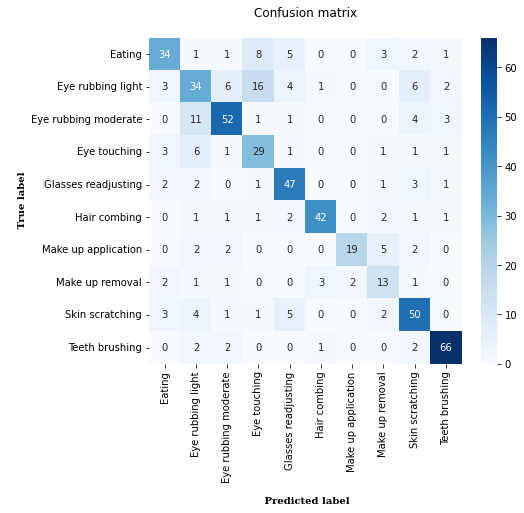

In [118]:
plt.figure(figsize=(7,6))
cm = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_title('Confusion matrix\n');
ax.set_xlabel('\n Predicted label', fontsize=10, fontfamily='serif', fontweight = 'bold')
ax.set_ylabel('\n True label', fontsize=10, fontfamily='serif', fontweight = 'bold');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(label_encoder.classes_[:-1], rotation=90)
ax.yaxis.set_ticklabels(label_encoder.classes_[:-1], rotation=0)
plt.savefig(base_folder+'Results/'+dataset_name+'_cm.png', bbox_inches='tight')
plt.show()

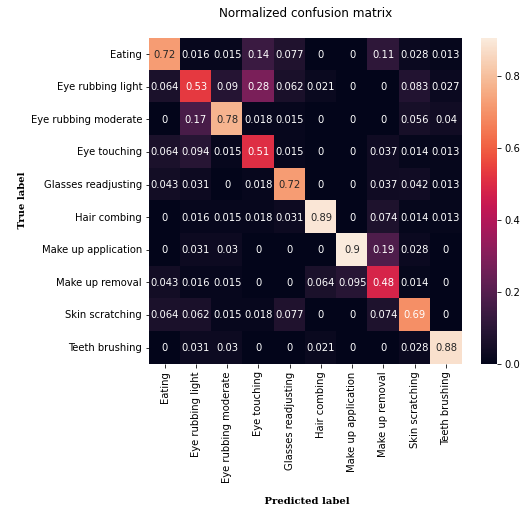

In [116]:
plt.figure(figsize=(7,6))
cm = confusion_matrix(y_true, y_pred)
cm = cm/cm.astype(np.float).sum(axis=0)
ax = sns.heatmap(cm, annot=True)
ax.set_title('Normalized confusion matrix\n');
ax.set_xlabel('\n Predicted label', fontsize=10, fontfamily='serif', fontweight = 'bold')
ax.set_ylabel('\n True label', fontsize=10, fontfamily='serif', fontweight = 'bold');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(label_encoder.classes_[:-1], rotation=90)
ax.yaxis.set_ticklabels(label_encoder.classes_[:-1], rotation=0)
plt.savefig(base_folder+'Results/'+dataset_name+'_cm_normalized.png', bbox_inches='tight')
plt.show()

In [117]:
acc = sklearn.metrics.accuracy_score(y_pred, y_true)
f1 = sklearn.metrics.f1_score(y_true, y_pred, average='macro')
print('Final performance on test set: {:.3f} test accuracy and {:.3f} f1 score'.format(acc,f1))

Final performance on test set: 0.712 test accuracy and 0.700 f1 score


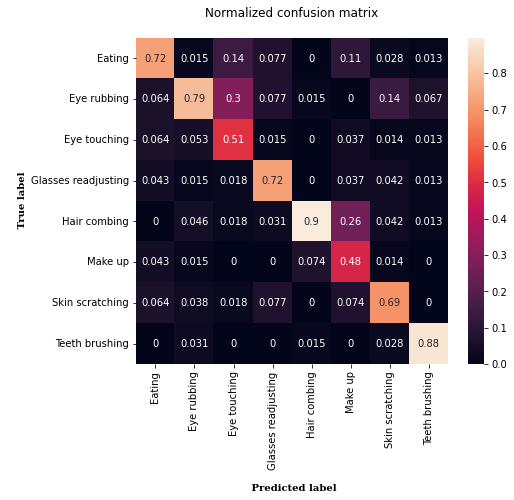

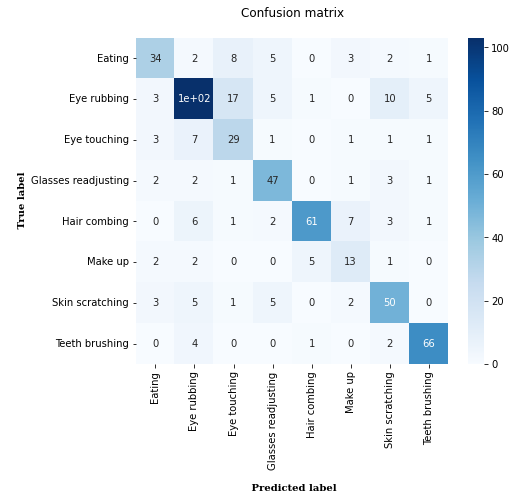

In [119]:
# Merge classes and visualize new predictions
def merge_classes(classes_names, y_pred, y_true, class1, class2, new_class):
  class1_idx = np.where(classes_names==class1)[0].item()
  class2_idx = np.where(classes_names==class2)[0].item()
  y_pred = np.array(y_pred)
  y_true = np.array(y_true)

  y_pred[np.where(y_pred==class1_idx)[0]] = np.full(
    shape=len(np.where(y_pred==class1_idx)[0]),
    fill_value=class2_idx,
    dtype=np.int
  )
  y_true[np.where(y_true==class1_idx)[0]] = np.full(
    shape=len(np.where(y_true==class1_idx)[0]),
    fill_value=class2_idx,
    dtype=np.int)
  
  classes_names[class2_idx] = new_class
  classes_names = np.delete(classes_names, class1_idx)

  return classes_names, y_pred, y_true

classes_names = label_encoder.classes_[:-1].copy()
classes_names, y_pred, y_true = merge_classes(classes_names, y_pred, y_true, 'Eye rubbing light', 'Eye rubbing moderate', 'Eye rubbing')
classes_names, y_pred, y_true = merge_classes(classes_names, y_pred, y_true, 'Make up application', 'Make up removal', 'Make up')

plt.figure(figsize=(7,6))
cm = confusion_matrix(y_true, y_pred)
cm = cm/cm.astype(np.float).sum(axis=0)
ax = sns.heatmap(cm, annot=True)
ax.set_title('Normalized confusion matrix\n');
ax.set_xlabel('\n Predicted label', fontsize=10, fontfamily='serif', fontweight = 'bold')
ax.set_ylabel('\n True label', fontsize=10, fontfamily='serif', fontweight = 'bold');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes_names, rotation=90)
ax.yaxis.set_ticklabels(classes_names, rotation=0)
plt.savefig(base_folder+'Results/'+dataset_name+'_cm_normalized_new.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,6))
cm = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_title('Confusion matrix\n');
ax.set_xlabel('\n Predicted label', fontsize=10, fontfamily='serif', fontweight = 'bold')
ax.set_ylabel('\n True label', fontsize=10, fontfamily='serif', fontweight = 'bold');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes_names, rotation=90)
ax.yaxis.set_ticklabels(classes_names, rotation=0)
plt.savefig(base_folder+'Results/'+dataset_name+'_cm_new.png', bbox_inches='tight')
plt.show()

In [120]:
acc = sklearn.metrics.accuracy_score(y_pred, y_true)
f1 = sklearn.metrics.f1_score(y_true, y_pred, average='macro')
print('Final performance on test set: {:.3f} test accuracy and {:.3f} f1 score'.format(acc,f1))


Final performance on test set: 0.744 test accuracy and 0.715 f1 score
